In [2]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from attention.img_proc.img_process import *
from attention.img_proc.img_split import *
from attention.models.face_models import *
from attention.utils.img_plot import *
from attention.utils.utilities import *
from attention.params import *
import copy

objc[73881]: Class CaptureDelegate is implemented in both /Users/amine/.pyenv/versions/3.10.6/envs/attention-env/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x1495824e8) and /Users/amine/.pyenv/versions/3.10.6/envs/attention-env/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x16b1ec860). One of the two will be used. Which one is undefined.
objc[73881]: Class CVWindow is implemented in both /Users/amine/.pyenv/versions/3.10.6/envs/attention-env/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x149582538) and /Users/amine/.pyenv/versions/3.10.6/envs/attention-env/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x13ffdca68). One of the two will be used. Which one is undefined.
objc[73881]: Class CVView is implemented in both /Users/amine/.pyenv/versions/3.10.6/envs/attention-env/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x149582560) and /Users/amine/.pyenv/versions/3.10.6/envs/attention-env/lib/python3.10/site-packages/me

In [3]:
# Get attention_data directory
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, os.pardir, "attention_data")

In [4]:
attention_df = pd.read_csv(os.path.join(data_directory, 'attention_output.csv')).sort_values(by=['timestamp', 'face_idx']).reset_index(drop=True)
attention_df.head()

,frame,timestamp,face_idx,recognition_prediction,recognition_distance,attentive,left_prediction,left_score,right_prediction,right_score,head_direction_prediction,head_direction_score,head_inclination_prediction,head_inclination_score
0,video2_ds350,350,0,Juliette,0.45,True,straight,0.55,straight,0.50,head centered,1.59,head level,1.67
1,video2_ds350,350,1,Cedric,0.55,True,straight,0.50,straight,0.50,head centered,0.97,head level,1.08
2,video2_ds350,350,2,Lancelot,0.40,True,straight,0.50,straight,0.57,head centered,1.33,head level,1.25
3,video2_ds350,350,3,Amine,0.48,False,straight,0.57,straight,0.50,head centered,0.68,head down,1.89
4,video2_ds350,350,4,Noah,0.51,True,straight,0.56,straight,0.46,head centered,1.42,head level,1.67


In [5]:
attention_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496 entries, 0 to 1495
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   frame                        1496 non-null   object 
 1   timestamp                    1496 non-null   int64  
 2   face_idx                     1496 non-null   int64  
 3   recognition_prediction       1417 non-null   object 
 4   recognition_distance         1432 non-null   float64
 5   attentive                    1496 non-null   bool   
 6   left_prediction              1496 non-null   object 
 7   left_score                   1496 non-null   float64
 8   right_prediction             1496 non-null   object 
 9   right_score                  1496 non-null   float64
 10  head_direction_prediction    1496 non-null   object 
 11  head_direction_score         1496 non-null   float64
 12  head_inclination_prediction  1496 non-null   object 
 13  head_inclination_s

In [6]:
attention_df.columns

Index(['frame', 'timestamp', 'face_idx', 'recognition_prediction',
       'recognition_distance', 'attentive', 'left_prediction', 'left_score',
       'right_prediction', 'right_score', 'head_direction_prediction',
       'head_direction_score', 'head_inclination_prediction',
       'head_inclination_score'],
      dtype='object')

### Creating time blocks to average metrics on block

In [7]:
grouping_factor = 10
timestamps = attention_df.timestamp.unique()
timestamp_dict = {timestamps[i]: timestamps[i - i % grouping_factor] for i in range(len(timestamps))}

In [8]:
attention_df['time_group'] = attention_df['timestamp'].map(timestamp_dict)
# attention_df

# Group metrics

### Focusing on attention

In [9]:
attention_sec = attention_df.groupby('timestamp')[['attentive']].mean()
# attention_sec.plot()

<Axes: xlabel='timestamp'>

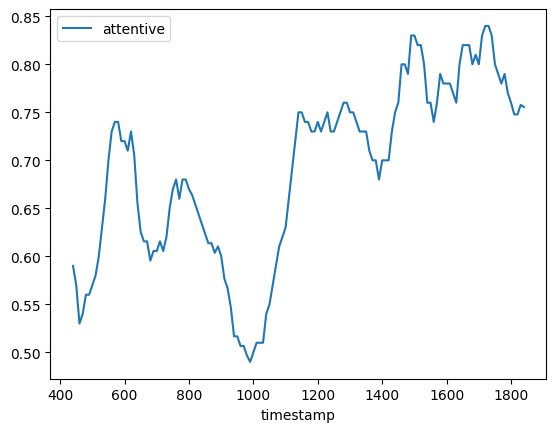

In [10]:
attention_ma = attention_sec.rolling(window=10).mean().dropna()
attention_ma.plot()

<Axes: xlabel='time_group'>

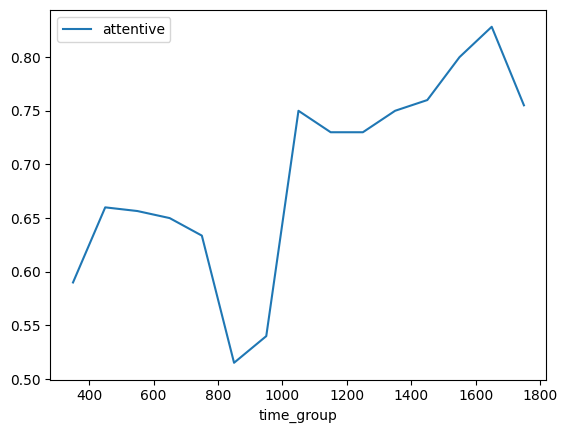

In [11]:
attention_block = attention_df.groupby('time_group')[['attentive']].mean()
attention_block.plot()

### Focus on detection

In [12]:
detection_sec = attention_df.groupby('timestamp').agg(
    {'time_group': 'first',
     'face_idx': 'count'})
# detection_sec.plot(y='attentive', use_index=True)

<Axes: xlabel='timestamp'>

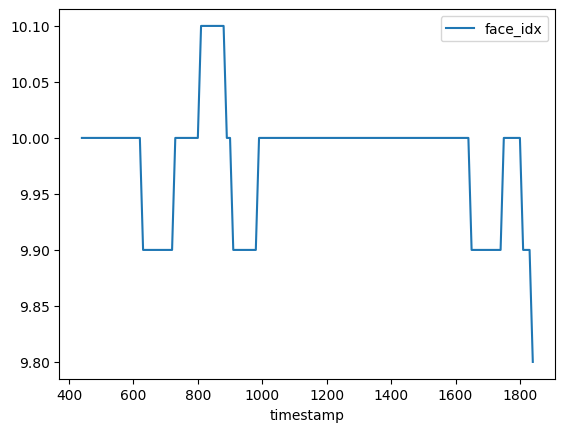

In [13]:
detection_ma = detection_sec.rolling(window=10).mean().dropna()
detection_ma.plot(y='face_idx', use_index=True)

<Axes: xlabel='time_group'>

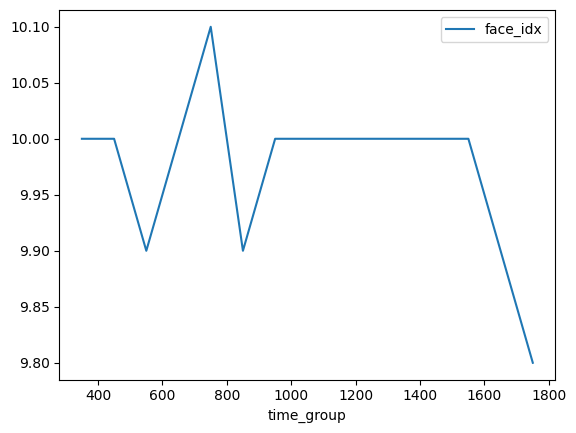

In [14]:
detection_block = detection_sec.groupby('time_group')[['face_idx']].mean()
detection_block.plot(y='face_idx', use_index=True)

### Focus on recognition

#### Number of people recognized

In [15]:
recognition_sec = attention_df.groupby(by='timestamp').agg(
    {'time_group': 'first',
     'recognition_prediction': lambda x: sum(~pd.isna(x))})
# recognition_sec.plot(y='recognition_prediction', use_index=True)

<Axes: xlabel='timestamp'>

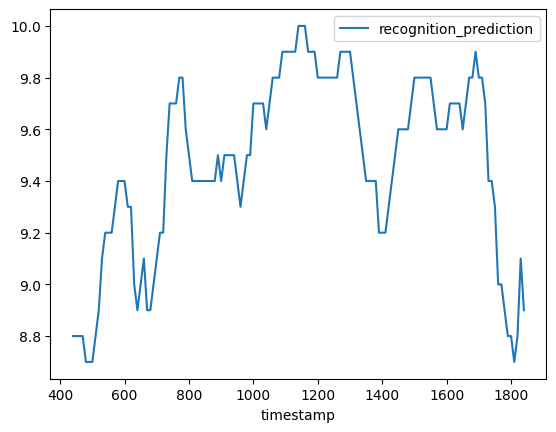

In [16]:
recognition_ma = recognition_sec.rolling(window=10).mean().dropna()
recognition_ma.plot(y='recognition_prediction', use_index=True)

<Axes: xlabel='time_group'>

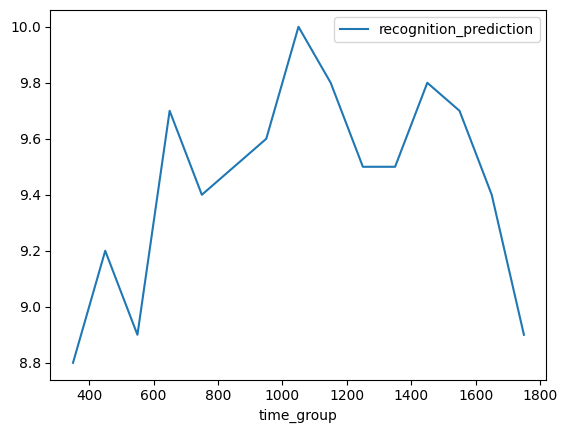

In [17]:
recognition_block = recognition_sec.groupby('time_group')[['recognition_prediction']].mean()
recognition_block.plot(y='recognition_prediction', use_index=True)

#### % people recognized (on detected)

<Axes: xlabel='timestamp'>

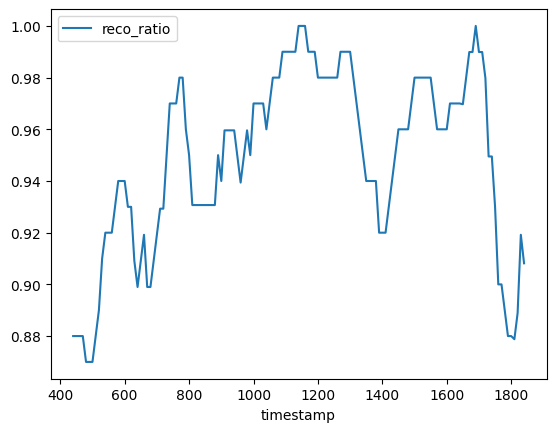

In [18]:
recognized_from_detected_ma = (recognition_ma['recognition_prediction'] / detection_ma['face_idx']).to_frame('reco_ratio')
recognized_from_detected_ma.plot()

## Individual metrics

In [19]:
target_person = 'Lancelot'
person_mask = attention_df['recognition_prediction'] == target_person

In [20]:
# Creating a dataframe with all timestamps available even if person is not recognized
time_df = pd.DataFrame(timestamp_dict.items(), columns=['timestamp', 'time_group'])
person_filter_df = attention_df[person_mask].drop(columns='time_group')
person_df = pd.merge(time_df, person_filter_df, how='left', on='timestamp').set_index('timestamp')

### Detection/ Recognition

<Axes: xlabel='timestamp'>

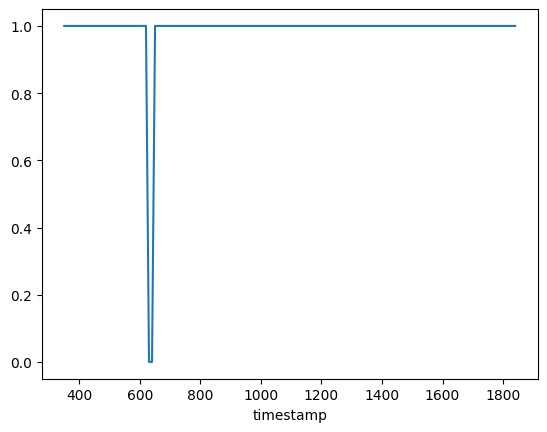

In [21]:
person_detection_sec = (~person_df['recognition_prediction'].isna()) * 1
person_detection_sec.plot()

<Axes: xlabel='timestamp'>

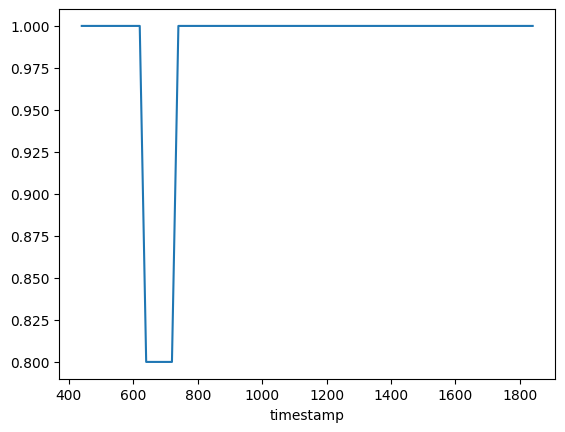

In [22]:
person_detection_ma = person_detection_sec.rolling(window=10).mean().dropna()
person_detection_ma.plot()

### Attention

In [23]:
person_attention_sec = person_df[['time_group', 'attentive']] * 1
# person_attention_sec.plot(y='attentive', use_index=True)

In [24]:
def average_nan(s: pd.Series, threshold: float = 0.4):
    na_rate = s.isna().sum() / len(s)
    return s.mean().round(2) if na_rate <= threshold else np.nan

<Axes: xlabel='time_group'>

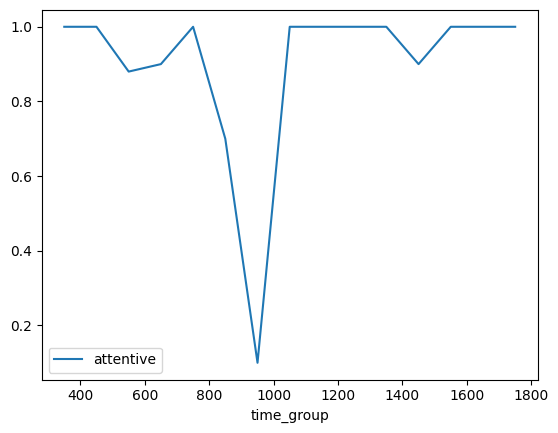

In [25]:
person_attention_block = person_attention_sec.groupby('time_group').agg(
    {'attentive': lambda s: average_nan(s, 0.2)}) 

person_attention_block.plot()

In [26]:
person_df.loc[850:949]

,time_group,frame,face_idx,recognition_prediction,recognition_distance,attentive,left_prediction,left_score,right_prediction,right_score,head_direction_prediction,head_direction_score,head_inclination_prediction,head_inclination_score
timestamp,,,,,,,,,,,,,,
850,850,video2_ds850,1.0,Lancelot,0.38,True,straight,0.62,straight,0.50,head centered,1.24,head level,1.36
860,850,video2_ds860,1.0,Lancelot,0.40,True,straight,0.50,straight,0.57,head centered,1.18,head level,1.60
870,850,video2_ds870,1.0,Lancelot,0.39,True,straight,0.62,straight,0.62,head centered,1.07,head level,1.25
880,850,video2_ds880,1.0,Lancelot,0.41,True,straight,0.62,straight,0.50,head centered,1.20,head level,1.25
890,850,video2_ds890,1.0,Lancelot,0.38,True,straight,0.57,straight,0.50,head centered,1.20,head level,1.36
900,850,video2_ds900,1.0,Lancelot,0.40,True,straight,0.50,straight,0.57,head centered,1.10,head level,1.36
910,850,video2_ds910,1.0,Lancelot,0.49,True,straight,0.25,straight,0.50,head centered,1.19,head level,1.60
920,850,video2_ds920,1.0,Lancelot,0.59,False,straight,0.29,straight,0.50,head centered,1.15,head down,2.43
930,850,video2_ds930,2.0,Lancelot,0.56,False,straight,0.38,straight,0.43,head centered,1.15,head down,2.43


In [30]:
attention_df[attention_df['recognition_prediction'].isna()]

,frame,timestamp,face_idx,recognition_prediction,recognition_distance,attentive,left_prediction,left_score,right_prediction,right_score,head_direction_prediction,head_direction_score,head_inclination_prediction,head_inclination_score,time_group
6,video2_ds350,350,6,NaN,NaN,False,straight,0.60,straight,0.20,head centered,1.13,head down,1.78,350
16,video2_ds360,360,6,NaN,NaN,True,straight,0.60,straight,0.50,head centered,1.06,head level,1.70,350
26,video2_ds370,370,6,NaN,NaN,False,straight,0.56,straight,0.40,head centered,1.11,head down,1.89,350
36,video2_ds380,380,6,NaN,NaN,False,straight,0.56,straight,0.33,head centered,0.96,head down,2.12,350
45,video2_ds390,390,5,NaN,NaN,True,straight,0.56,straight,0.40,head centered,1.21,head level,1.50,350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415,video2_ds1760,1760,7,NaN,NaN,False,straight,0.43,straight,0.57,head centered,0.92,head down,2.00,1750
1435,video2_ds1780,1780,7,NaN,NaN,False,straight,0.57,sideway,0.67,head centered,0.92,head down,2.00,1750
1440,video2_ds1790,1790,2,NaN,0.63,False,straight,0.57,straight,0.40,head right,2.04,head level,1.09,1750
1449,video2_ds1800,1800,1,NaN,0.62,True,straight,0.57,straight,0.50,head centered,1.61,head level,1.00,1750
